<a href="https://colab.research.google.com/github/KunalParkhade/credit-card-fraud-detection/blob/main/Credit_Card.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Card Fraud Detection Using Spectral Clustering

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

In [46]:
data = pd.read_csv('/content/drive/MyDrive/Datasets/creditcardcsvpresent.csv', header='infer')
data.head()

,Merchant_id,Transaction date,Average Amount/transaction/day,Transaction_amount,Is declined,Total Number of declines/day,isForeignTransaction,isHighRiskCountry,Daily_chargeback_avg_amt,6_month_avg_chbk_amt,6-month_chbk_freq,isFradulent
0,3160040998,NaN,100.0,3000.0,N,5,Y,Y,0,0.0,0,Y
1,3160040998,NaN,100.0,4300.0,N,5,Y,Y,0,0.0,0,Y
2,3160041896,NaN,185.5,4823.0,Y,5,N,N,0,0.0,0,Y
3,3160141996,NaN,185.5,5008.5,Y,8,N,N,0,0.0,0,Y
4,3160241992,NaN,500.0,26000.0,N,0,Y,Y,800,677.2,6,Y


In [47]:
data["Is declined"] = data["Is declined"].apply(lambda x: 1 if x == "Y" else 0)
data["isForeignTransaction"] = data["isForeignTransaction"].apply(lambda x: 1 if x == "Y" else 0)
data["isHighRiskCountry"] = data["isHighRiskCountry"].apply(lambda x: 1 if x == "Y" else 0)
data["isFradulent"] = data["isFradulent"].apply(lambda x: 1 if x == "Y" else 0)

In [48]:
data = data.drop(["Merchant_id", "Transaction date"], axis=1)
data.head()

,Average Amount/transaction/day,Transaction_amount,Is declined,Total Number of declines/day,isForeignTransaction,isHighRiskCountry,Daily_chargeback_avg_amt,6_month_avg_chbk_amt,6-month_chbk_freq,isFradulent
0,100.0,3000.0,0,5,1,1,0,0.0,0,1
1,100.0,4300.0,0,5,1,1,0,0.0,0,1
2,185.5,4823.0,1,5,0,0,0,0.0,0,1
3,185.5,5008.5,1,8,0,0,0,0.0,0,1
4,500.0,26000.0,0,0,1,1,800,677.2,6,1


In [49]:
data.isFradulent.value_counts()

,count
isFradulent,
0,2627
1,448


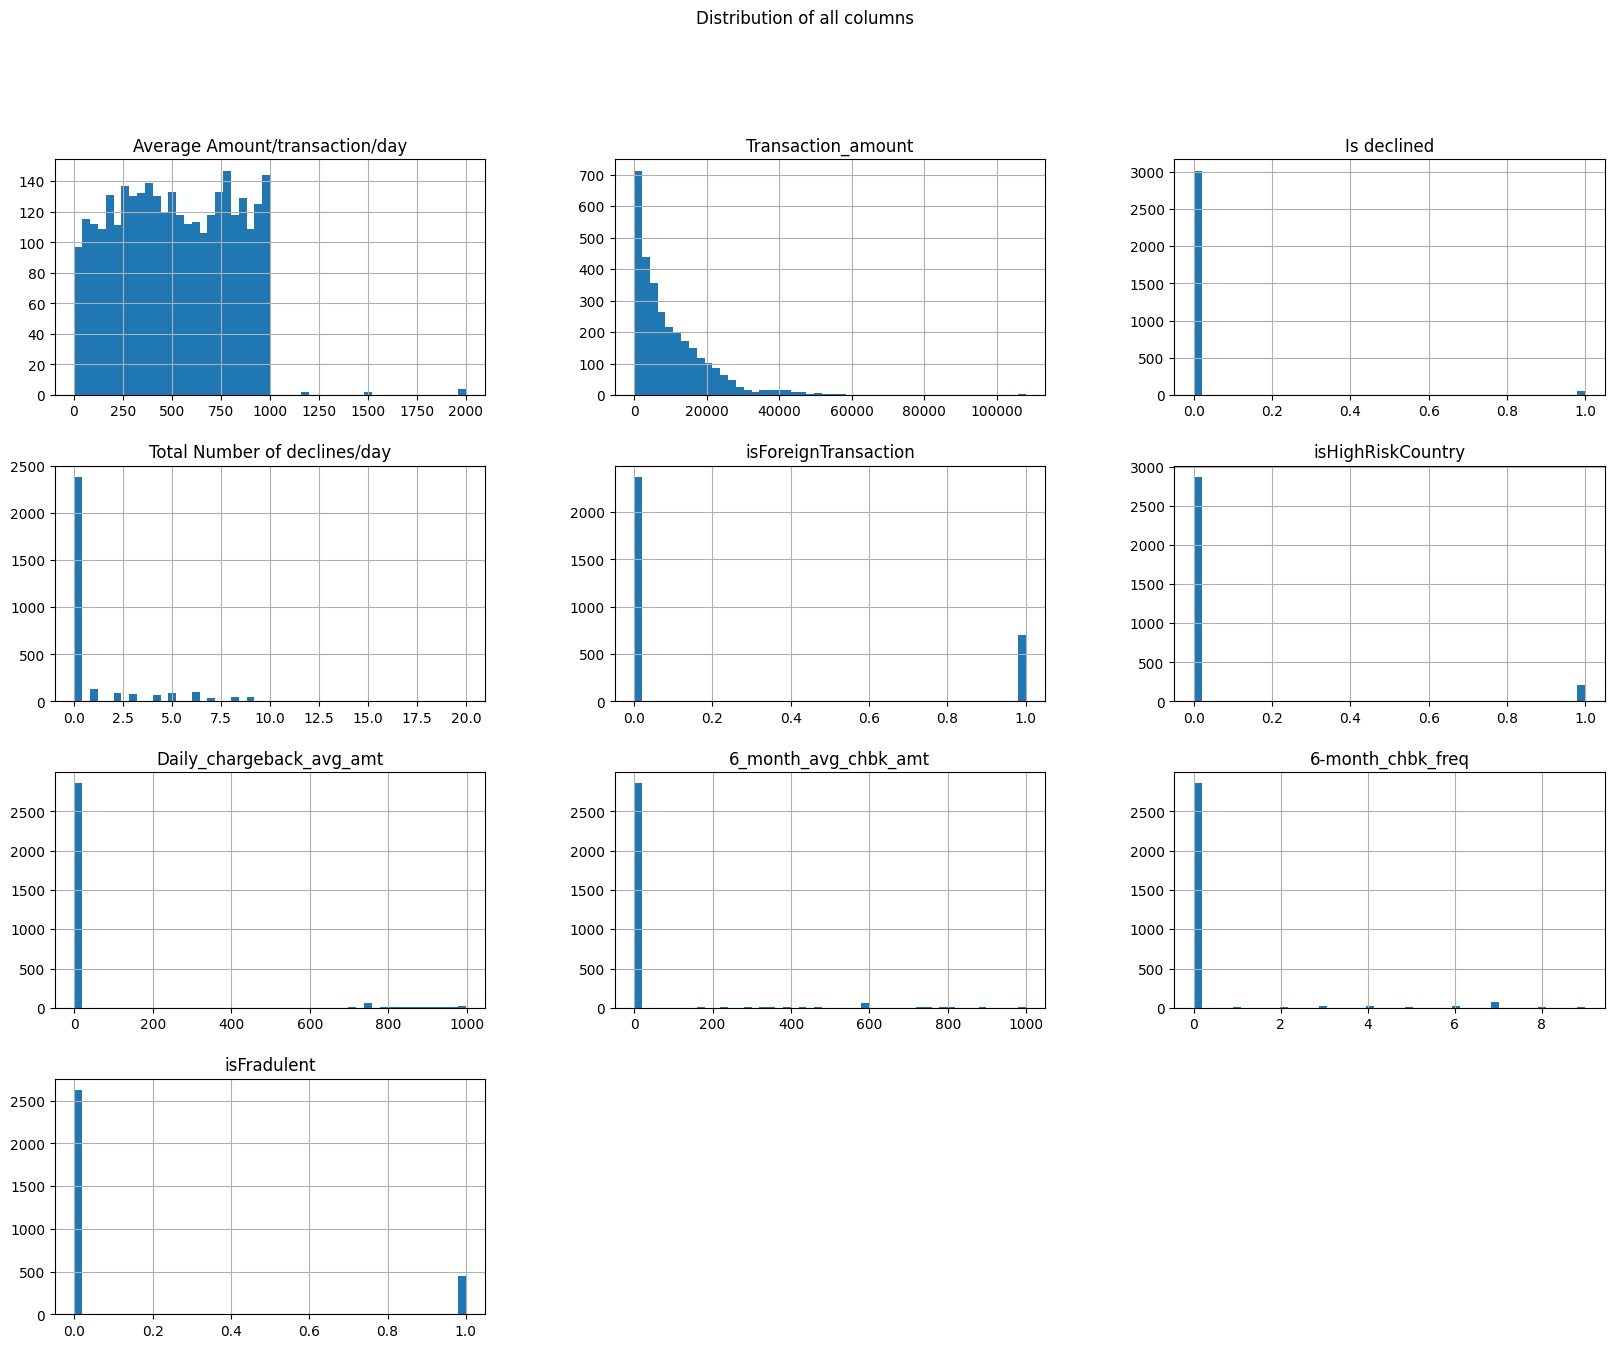

In [50]:
# Plotting the distribution of all columns
data.hist(bins=50, figsize=(20, 15))
plt.suptitle("Distribution of all columns")
plt.show()

The `MinMaxScaler` transforms features by scaling each feature to a given range, typically between 0 and 1

In [51]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X = data.loc[:, data.columns != "isFradulent"].to_numpy()
y_true = data["isFradulent"].to_numpy()

X_scaled = scaler.fit_transform(X)
X.shape

(3075, 9)

In [52]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_kernels

def laplacian_eigen_decomposition(X, sigma=1.0):
    # Step 1: Construct the similarity matrix
    W = pairwise_kernels(X, metric='rbf', gamma=1/(2*sigma**2))
    # Step 2: Compute the degree matrix
    D = np.diag(np.sum(W, axis=1))
    # Step 3: Compute the graph Laplacian
    L_sym = D -  W
    # Step 4: Eigenvalue decomposition
    eigvals, eigvecs = np.linalg.eigh(L_sym)
    return eigvals, eigvecs


def clustering(U, k):
    # Step 5: Normalize rows of U
    U_normalized = U / np.linalg.norm(U, axis=1, keepdims=True)
    # Step 6: Apply k-means to rows of U
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(U_normalized)
    return labels, kmeans.cluster_centers_

Here, we are implementing a spectral clustering algorithm, which involves using the eigenvalues and eigenvectors of a graph Laplacian matrix to perform clustering. We start by importing necessary libraries: `numpy` for numerical operations, `KMeans` from `sklearn.cluster` for clustering, and `pairwise_kernels` from `sklearn.metrics` for computing the similarity matrix.

[-1.66847350e-12  3.21309424e+02  3.60926345e+02 ...  2.59908571e+03
  2.59911988e+03  2.59931858e+03]


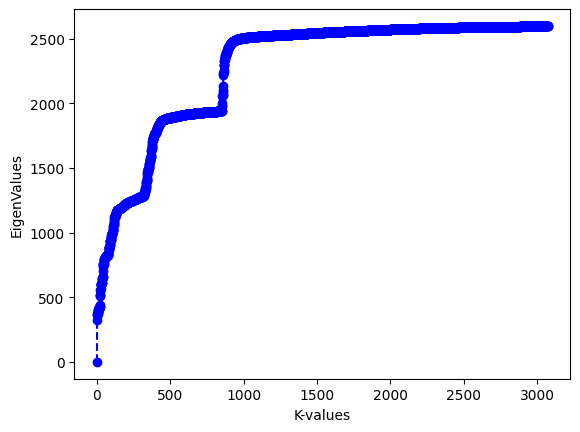

In [53]:
eigvals, eigvecs = laplacian_eigen_decomposition(X_scaled, sigma=1)
print(eigvals)

# plot of eigen values
plt.ylabel('EigenValues')
plt.xlabel('K-values')
plt.plot(np.array(eigvals).tolist(), linestyle='--', marker='o', color='b')
plt.show()

From the plot, we can see that there is a large gap between the first and second eigenvalues. The Eigengap heuristic indicates that we will ideally need only one cluster to identify fraudulent transactions. However, in this project, we will cluster the dataset into 2 partitions so that we can show the next steps involved in the spectral clustering. Ideally choosing one or two clusters in this case should result in similar performance.

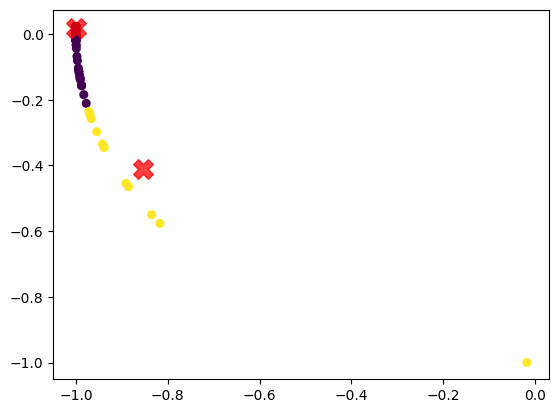

In [54]:
K = 2
U = eigvecs[:, :K]
cluster_labels, cluster_centers = clustering(U, k=K)

# Plot the clusters
U_normalized = U / np.linalg.norm(U, axis=1, keepdims=True)
plt.scatter(U_normalized[:, 0], U_normalized[:, 1], c=cluster_labels, s=30)
# Plot the centroids

plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=200, alpha=0.75, marker='X')
plt.show()

How do we use these cluster assignments to identify point anomalies (or fraudulent transactions)?

- >The idea is to iterate through each cluster and flag those data points which deviate significantly from their corresponding distribution.

For measuring this deviation, we can use the Z-Score method that measures how many standard deviations a point is from the mean (cluster centroid in this case). Data points with a Z-score above a certain threshold (e.g., 2) are considered anomalies (or fraudulent transactions).

In [55]:
from scipy.stats import zscore
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
z_score_threshold = 3 # for z = 4, I got Precision: 0.75 Recall: 0.32

# Identify fraud transactions within each cluster using z-score method
fraud_predictions = pd.Series(0, index=data.index)  # Initialize all as non-fraud
for cluster in range(K):
    cluster_data = X_scaled[cluster_labels == cluster]
    print(f"Data points in cluster {cluster} : {cluster_data.shape[0]}")
    cluster_z_scores = zscore(cluster_data)
    fraud_indices = (abs(cluster_z_scores) > z_score_threshold).any(axis=1)  # Identify outliers
    fraud_predictions[cluster_labels == cluster] = fraud_indices.astype(np.int64)
fraud_predictions = fraud_predictions.to_numpy(dtype='int64')

Data points in cluster 0 : 3062
Data points in cluster 1 : 13


In [56]:
# Calculate precision and recall
precision = precision_score(y_true, fraud_predictions)
recall = recall_score(y_true, fraud_predictions)
f1score = f1_score(y_true, fraud_predictions)
confusion_matrix = confusion_matrix(y_true, fraud_predictions)

# Print the results
print("Confusion Matrix:")
print(confusion_matrix)
print(f'F1 Score: {f1score:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

Confusion Matrix:
[[2563   64]
 [  84  364]]
F1 Score: 0.83
Precision: 0.85
Recall: 0.81


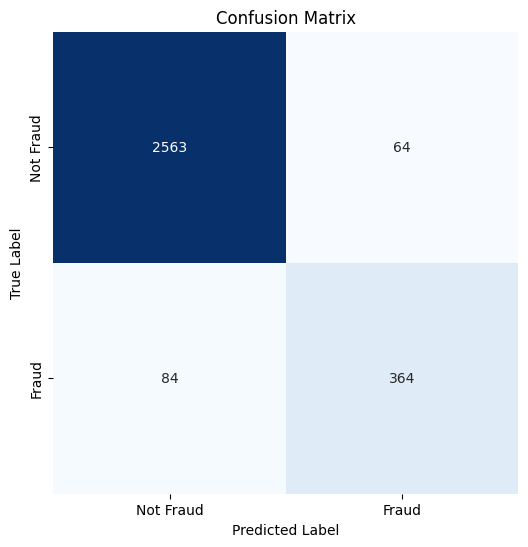

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, fraud_predictions)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()